# Explore CMIP6 data on Casper

Ensure you have the required libraries installed, these will make it much easier to work with the data

In [1]:
! pip install netcdf4 xarray[io] cartopy nc-time-axis

Defaulting to user installation because normal site-packages is not writeable
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.8/60.8 kB 1.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.0/56.0 kB 885.4 kB/s eta 0:00:00a 0:00:01
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.0/9.0 MB 67.6 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.7/11.7 MB 128.3 MB/s eta 0:00:0000:010:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 65.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.2/9.2 MB 83.7 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.5/46.5 kB 3.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 93.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.0/50.0 kB 4.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.6/64.6 kB 5.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.2/41.2 MB 7

In [2]:
import pandas as pd
import xarray as xr
import numpy as np
import os.path

import matplotlib.pyplot as plt
# Useful for plotting maps
import cartopy.crs as ccrs

# This can be useful for working with multiple processors - to be explored later on
# from dask.distributed import Client, LocalCluster

Output data is in `/glade/collections/cmip/CMIP6/{activity}/NCC/NorESM2-LM/{experiment}`

You can also find other model data here, in particular the NCAR model:
Example path: `/glade/collections/cmip/CMIP6/DAMIP/NCAR/CESM2/hist-aer/r1i1p1f1/Amon/tas/gn/latest/*.nc`



Input data is in: `/glade/p/cesmdata/cseg/inputdata/atm/cam/chem/emis/`

The model names are not very obvious but you can either google them, ask ChatGPT, or look them up in these structured dictionaries: https://github.com/PCMDI/cmip6-cmor-tables/tree/main/Tables (which can be queried with e.g. Pandas)

In [3]:
def get_MIP(experiment):
    """
    Utility function to get teh activity associated with a particular experiment
    """
    if experiment == 'ssp245-covid':
        return 'DAMIP'
    elif experiment == 'ssp370-lowNTCF':
        return 'AerChemMIP'
    elif experiment.startswith('ssp'):
        return 'ScenarioMIP'
    elif experiment.startswith('hist-'):
        return 'DAMIP'
    else:
        return 'CMIP'


In [4]:
def get_data(variable, experiment, member):
    """
    Read a particular CMIP6 (Amon) variable from NorESM2
    """
    import glob
    files = glob.glob(f"/glade/collections/cmip/CMIP6/{get_MIP(experiment)}/NCC/NorESM2-LM/{experiment}/{member}/Amon/{variable}/gn/v20190815/{variable}/*.nc")
    return xr.open_mfdataset(files)[variable]

In [5]:
tas = get_data('tas', 'historical', 'r1i1p1f1')

*Note*, the ensemble member format: 
`r` for realization, `i` for initialization, `p` for physics, and `f` for forcing

We're only interested in different realizations in this project, so try different r numbers but keep the rest the same: E.g.: `r1i1p1f1`, `r2i1p1f1`, `r3i1p1f1`

In [6]:
# When averaging gridded data on a sphere, we need to account for the fact that the values near the poles have less area
weights = np.cos(np.deg2rad(tas.lat))
weights.name = "weights"

tas_timeseries = tas.weighted(weights).mean(['lat', 'lon'])

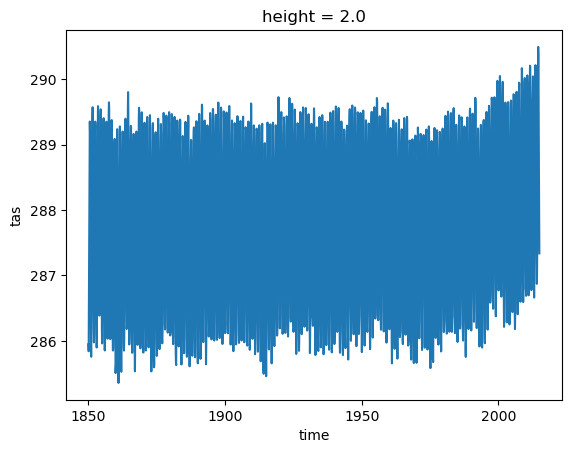

In [7]:
tas_timeseries.plot()

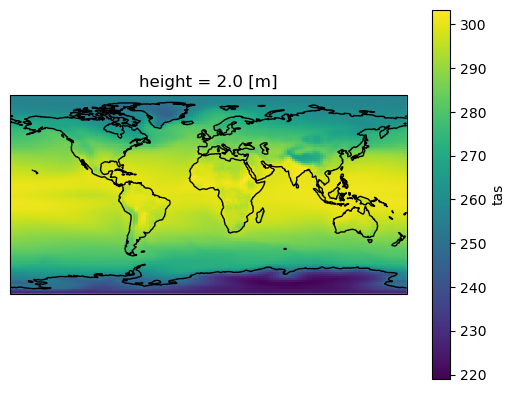

In [8]:
# Plot a map of the average temperature between 1850-1900

tas.sel(time=slice('1850','1900')).mean('time').plot(
    transform=ccrs.PlateCarree(), # This is the projection the data is stored as
    subplot_kws={"projection": ccrs.PlateCarree()}, # This describes the projection to plot onto (which happens to be the projection the data is already in so no transformation is needed in this case)
)

# Feel free to explore other projections here: https://scitools.org.uk/cartopy/docs/v0.15/crs/projections.html

plt.gca().coastlines()

In [9]:
tas

<xarray.DataArray 'tas' (time: 1980, lat: 96, lon: 144)> Size: 109MB
dask.array<concatenate, shape=(1980, 96, 144), dtype=float32, chunksize=(1, 96, 144), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) object 16kB 1850-01-16 12:00:00 ... 2014-12-16 12:00:00
  * lat      (lat) float64 768B -90.0 -88.11 -86.21 -84.32 ... 86.21 88.11 90.0
  * lon      (lon) float64 1kB 0.0 2.5 5.0 7.5 10.0 ... 350.0 352.5 355.0 357.5
    height   float64 8B 2.0
Attributes:
    standard_name:  air_temperature
    long_name:      Near-Surface Air Temperature
    comment:        near-surface (usually, 2 meter) air temperature
    units:          K
    original_name:  TREFHT
    cell_methods:   area: time: mean
    cell_measures:  area: areacella
    history:        2019-08-15T12:42:20Z altered by CMOR: Treated scalar dime...

In [10]:
tas.coords

Coordinates:
  * time     (time) object 16kB 1850-01-16 12:00:00 ... 2014-12-16 12:00:00
  * lat      (lat) float64 768B -90.0 -88.11 -86.21 -84.32 ... 86.21 88.11 90.0
  * lon      (lon) float64 1kB 0.0 2.5 5.0 7.5 10.0 ... 350.0 352.5 355.0 357.5
    height   float64 8B 2.0

### Average temp between 2005-2015

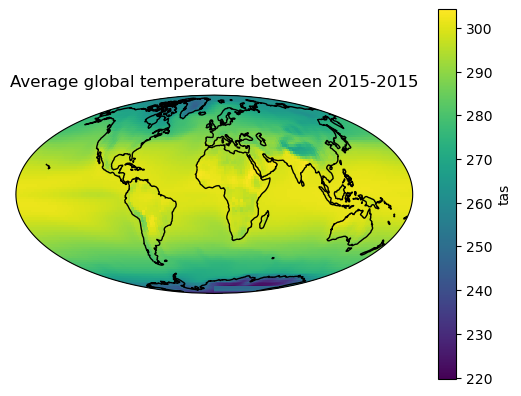

In [ ]:
tas2005_2015 = tas.sel(time=slice('2005', '2015')).mean(['time'])
tas2005_2015.plot(transform=ccrs.PlateCarree(), subplot_kws={"projection": ccrs.Mollweide()})
plt.title('Average global temperature between 2005-2015')
plt.gca().coastlines()

### Difference in global temp from 1850-1900

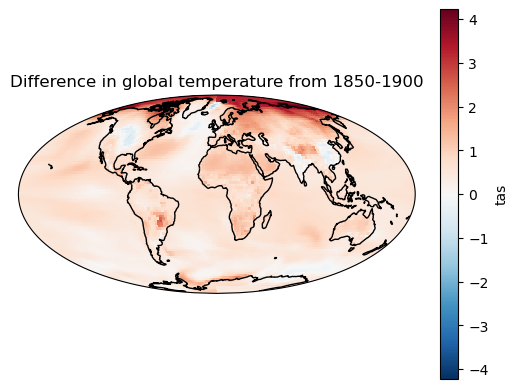

In [12]:
tas1850_1900 = tas.sel(time=slice('1850', '1900')).mean(['time'])
(tas2005_2015 - tas1850_1900).plot(transform=ccrs.PlateCarree(), subplot_kws={"projection": ccrs.Mollweide()})
plt.title('Difference in global temperature from 1850-1900')
plt.gca().coastlines()

### Precipitation

In [13]:
pr = get_data('pr', 'historical', 'r1i1p1f1')

In [14]:
pr

<xarray.DataArray 'pr' (time: 1980, lat: 96, lon: 144)> Size: 109MB
dask.array<concatenate, shape=(1980, 96, 144), dtype=float32, chunksize=(1, 96, 144), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) object 16kB 1850-01-16 12:00:00 ... 2014-12-16 12:00:00
  * lat      (lat) float64 768B -90.0 -88.11 -86.21 -84.32 ... 86.21 88.11 90.0
  * lon      (lon) float64 1kB 0.0 2.5 5.0 7.5 10.0 ... 350.0 352.5 355.0 357.5
Attributes:
    standard_name:  precipitation_flux
    long_name:      Precipitation
    comment:        includes both liquid and solid phases
    units:          kg m-2 s-1
    original_name:  PRECC+PRECL
    cell_methods:   area: time: mean
    cell_measures:  area: areacella
    history:        2020-06-04T20:38:11Z altered by CMOR: Converted type from...

In [15]:
pr1850_1900 = pr.sel(time=slice('1850', '1900')).mean(['time'])
pr2005_2015 = pr.sel(time=slice('2005', '2015')).mean(['time'])

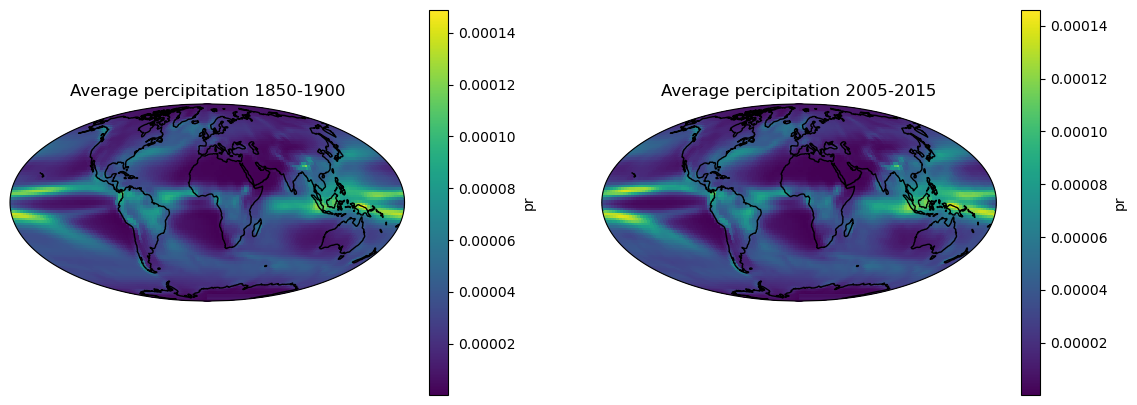

In [16]:
fig, axs = plt.subplots(1, 2, subplot_kw={'projection': ccrs.Mollweide()}, figsize=(14,5))
pr1850_1900.plot(transform=ccrs.PlateCarree(), ax=axs[0])
pr2005_2015.plot(transform=ccrs.PlateCarree(), ax=axs[1])

axs[0].coastlines()
axs[0].title.set_text('Average percipitation 1850-1900')
axs[1].coastlines()
axs[1].title.set_text('Average percipitation 2005-2015')

plt.show()

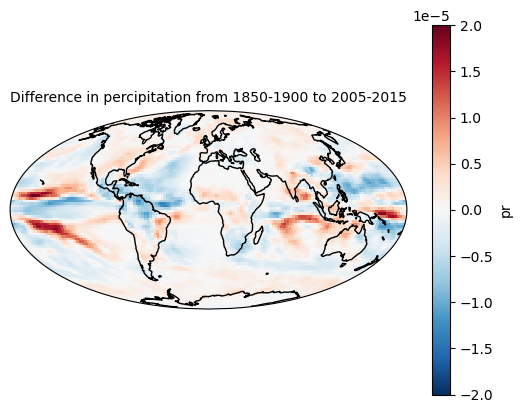

In [17]:
# Plot difference
pr_diff = pr2005_2015 - pr1850_1900
pr_diff.plot(transform=ccrs.PlateCarree(), subplot_kws={'projection': ccrs.Mollweide()})

plt.title('Difference in percipitation from 1850-1900 to 2005-2015', fontsize=10)
plt.gca().coastlines()

### Daily Maximum Temperature

In [18]:
def get_tasmax(experiment, member):
    """
    Read a particular CMIP6 (Amon) variable from NorESM2
    """
    import glob
    files = glob.glob(f"/glade/collections/cmip/CMIP6/{get_MIP(experiment)}/NCC/NorESM2-LM/{experiment}/{member}/day/tasmax/gn/v20190815/tasmax/*.nc")
    return xr.open_mfdataset(files)['tasmax']

tasmax = get_tasmax('historical', 'r1i1p1f1')
tasmax

<xarray.DataArray 'tasmax' (time: 60225, lat: 96, lon: 144)> Size: 3GB
dask.array<concatenate, shape=(60225, 96, 144), dtype=float32, chunksize=(1, 96, 144), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) object 482kB 1850-01-01 12:00:00 ... 2014-12-31 12:00:00
  * lat      (lat) float64 768B -90.0 -88.11 -86.21 -84.32 ... 86.21 88.11 90.0
  * lon      (lon) float64 1kB 0.0 2.5 5.0 7.5 10.0 ... 350.0 352.5 355.0 357.5
    height   float64 8B 2.0
Attributes:
    standard_name:  air_temperature
    long_name:      Daily Maximum Near-Surface Air Temperature
    comment:        maximum near-surface (usually, 2 meter) air temperature (...
    units:          K
    original_name:  TREFHTMX
    cell_methods:   area: mean time: maximum
    cell_measures:  area: areacella
    history:        2019-08-15T16:41:37Z altered by CMOR: Treated scalar dime...

In [19]:
tasmax1850_1900 = tasmax.sel(time=slice('1850', '1900')).mean('time').compute()
tasmax2005_2015 = tasmax.sel(time=slice('2005', '2015')).mean('time').compute()

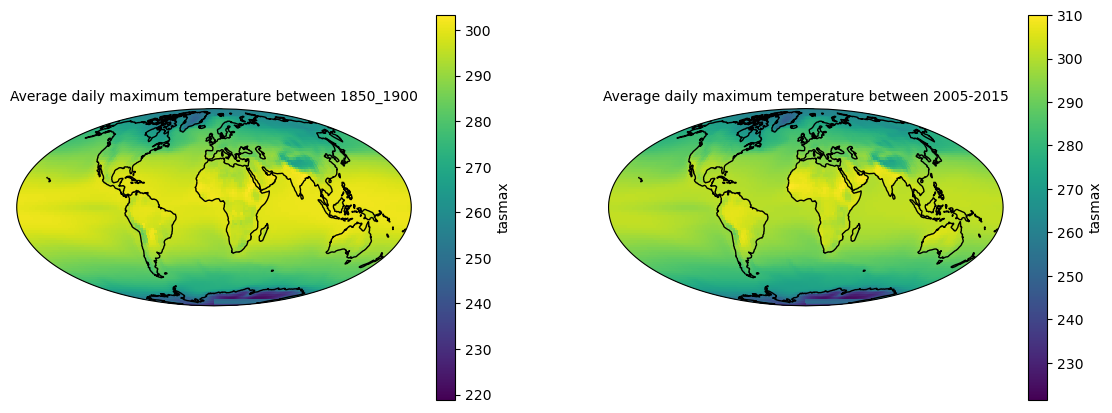

In [20]:
fig, axs = plt.subplots(1, 2, figsize=(14, 5), subplot_kw={'projection': ccrs.Mollweide()})

tasmax1850_1900.plot(ax=axs[0], transform=ccrs.PlateCarree())
tasmax2005_2015.plot(ax=axs[1], transform=ccrs.PlateCarree())

axs[0].set_title('Average daily maximum temperature between 1850_1900', fontsize=10)
axs[0].coastlines()
axs[1].set_title('Average daily maximum temperature between 2005-2015', fontsize=10)
axs[1].coastlines()

plt.show()

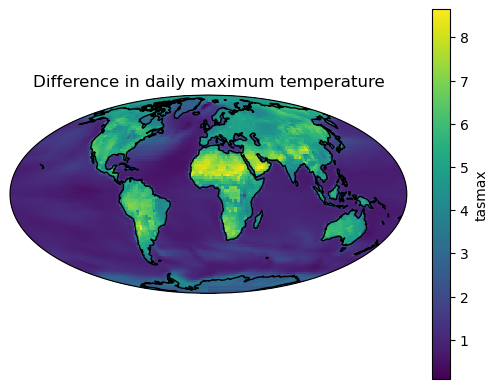

In [21]:
# Plot difference
tasmax_diff = tasmax2005_2015 - tasmax1850_1900
tasmax_diff.plot(transform=ccrs.PlateCarree(), subplot_kws={'projection': ccrs.Mollweide()})
plt.title('Difference in daily maximum temperature')
plt.gca().coastlines()

### Time series

In [22]:
def get_ensemble_data(variable, experiment, member):
    """
    Read a particular CMIP6 (Amon) variable from NorESM2
    """
    import glob
    files = glob.glob(f"/glade/collections/cmip/CMIP6/{get_MIP(experiment)}/NCC/NorESM2-LM/{experiment}/{member}/Amon/{variable}/gn/v20190920/{variable}/*.nc")
    return xr.open_mfdataset(files)[variable]


r2_pr = get_ensemble_data('pr', 'historical', 'r2i1p1f1')
r3_pr = get_ensemble_data('pr', 'historical', 'r3i1p1f1')

In [23]:
pr_timeseries = pr.weighted(weights).mean(['lat', 'lon']).compute()
r2_pr_timeseries = r2_pr.weighted(weights).mean(['lat', 'lon']).compute()
r3_pr_timeseries = r3_pr.weighted(weights).mean(['lat', 'lon']).compute()

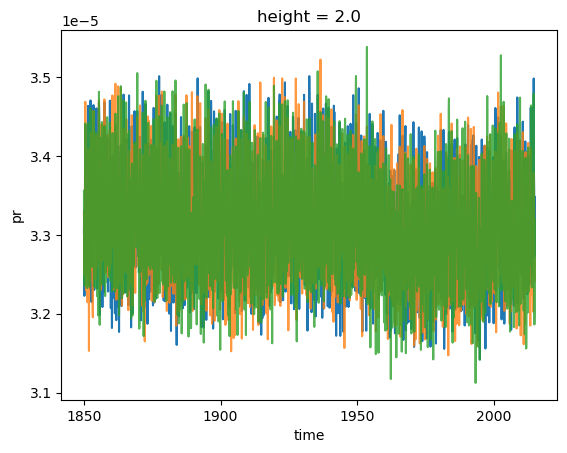

In [24]:
pr_timeseries.plot()
r2_pr_timeseries.plot(alpha=0.8)
r3_pr_timeseries.plot(alpha=0.8)

In [25]:
def get_tasmax_ensemble(experiment, member):
    """
    Read a particular CMIP6 (Amon) variable from NorESM2
    """
    import glob
    files = glob.glob(f"/glade/collections/cmip/CMIP6/{get_MIP(experiment)}/NCC/NorESM2-LM/{experiment}/{member}/day/tasmax/gn/v20190920/tasmax/*.nc")
    return xr.open_mfdataset(files)['tasmax']

r2_tasmax = get_tasmax_ensemble('historical', 'r2i1p1f1')
r3_tasmax = get_tasmax_ensemble('historical', 'r3i1p1f1')

In [26]:
tasmax_timeseries = tasmax.weighted(weights).mean(['lat', 'lon']).compute()

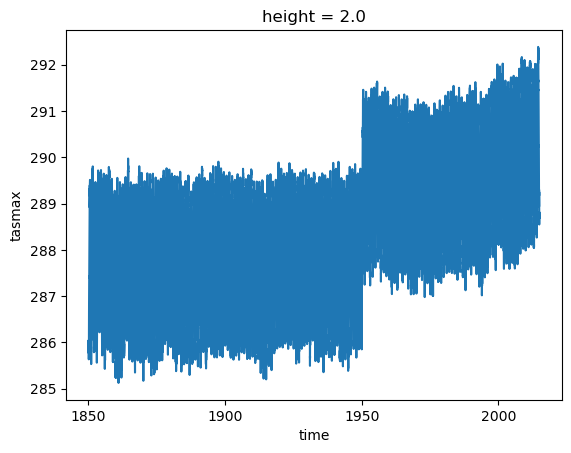

In [27]:
tasmax_timeseries.plot()

### Near-surface specific humidity

In [28]:
# huss: Near-surface specific humidity

huss = get_data('huss', 'historical', 'r1i1p1f1')
huss

<xarray.DataArray 'huss' (time: 1980, lat: 96, lon: 144)> Size: 109MB
dask.array<concatenate, shape=(1980, 96, 144), dtype=float32, chunksize=(1, 96, 144), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) object 16kB 1850-01-16 12:00:00 ... 2014-12-16 12:00:00
  * lat      (lat) float64 768B -90.0 -88.11 -86.21 -84.32 ... 86.21 88.11 90.0
  * lon      (lon) float64 1kB 0.0 2.5 5.0 7.5 10.0 ... 350.0 352.5 355.0 357.5
    height   float64 8B 2.0
Attributes:
    standard_name:   specific_humidity
    long_name:       Near-Surface Specific Humidity
    comment:         Near-surface (usually, 2 meter) specific humidity.
    units:           1
    original_name:   QREFHT
    original_units:  kg/kg
    history:         2019-08-15T12:02:42Z altered by CMOR: Converted units fr...
    cell_methods:    area: time: mean
    cell_measures:   area: areacella

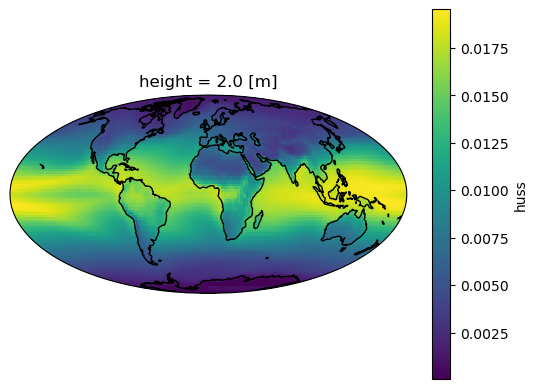

In [29]:
huss.mean('time').plot(transform=ccrs.PlateCarree(), subplot_kws={'projection': ccrs.Mollweide()})
plt.gca().coastlines()

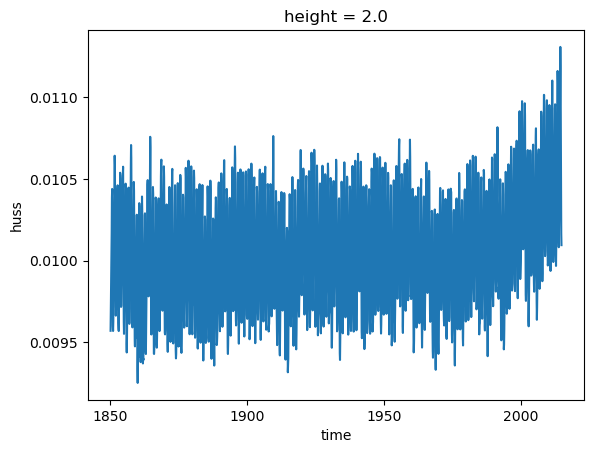

In [30]:
huss_timeseries = huss.weighted(weights).mean(['lat', 'lon'])
huss_timeseries.plot()